In [1]:
from collections import defaultdict
from datetime import datetime
import random
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import norm, exponnorm
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

%matplotlib notebook

In [2]:
all_years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/years.csv")

In [3]:
all_team_years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/team_years.csv")
all_events_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/events.csv")
all_matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/matches.csv")
all_team_matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/team_matches.csv")

/var/folders/t4/y6fltgk127g2nzwpqv5mcmd40000gn/T/ipykernel_3519/2756049137.py:3: DtypeWarning: Columns (12,13,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  all_matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/matches.csv")


In [4]:
all_matches_df = pd.merge(all_matches_df, all_events_df[["key", "week"]], left_on="event", right_on="key").rename(columns={"key_x": "key"}).drop(columns=["key_y"])

In [5]:
year = 2023

team_years_df = all_team_years_df[all_team_years_df.year == year]
matches_df = all_matches_df[(all_matches_df.year == year) & (all_matches_df.status == "Completed") & (all_matches_df.offseason == False)].sort_values(by=["time"])
team_matches_df = all_team_matches_df[(all_team_matches_df.year == year)]

In [6]:
team_matches_dict = defaultdict(dict)
for _, team_match in team_matches_df.iterrows():
    team_matches_dict[team_match.match][team_match.team] = team_match.epa

In [7]:
all_data = []
data = []

def red_accessor(match):
    if year >= 2016:
        return match.red_no_fouls
    return match.red_score

def blue_accessor(match):
    if year >= 2016:
        return match.blue_no_fouls
    return match.blue_score

for _, match in matches_df.iterrows():
    if match.status == "Upcoming" or math.isnan(red_accessor(match)):
        continue 
        
    curr_epas = team_matches_dict[match.key]
    red_epas = sorted([curr_epas[match.red_1], curr_epas[match.red_2], curr_epas[match.red_3]], reverse=True)
    blue_epas = sorted([curr_epas[match.blue_1], curr_epas[match.blue_2], curr_epas[match.blue_3]], reverse=True)
    if match.week != 8:
        data.append([red_epas, red_accessor(match)])
        data.append([blue_epas, blue_accessor(match)]) 
    all_data.append([red_epas, red_accessor(match)])
    all_data.append([blue_epas, blue_accessor(match)])

<IPython.core.display.Javascript object>


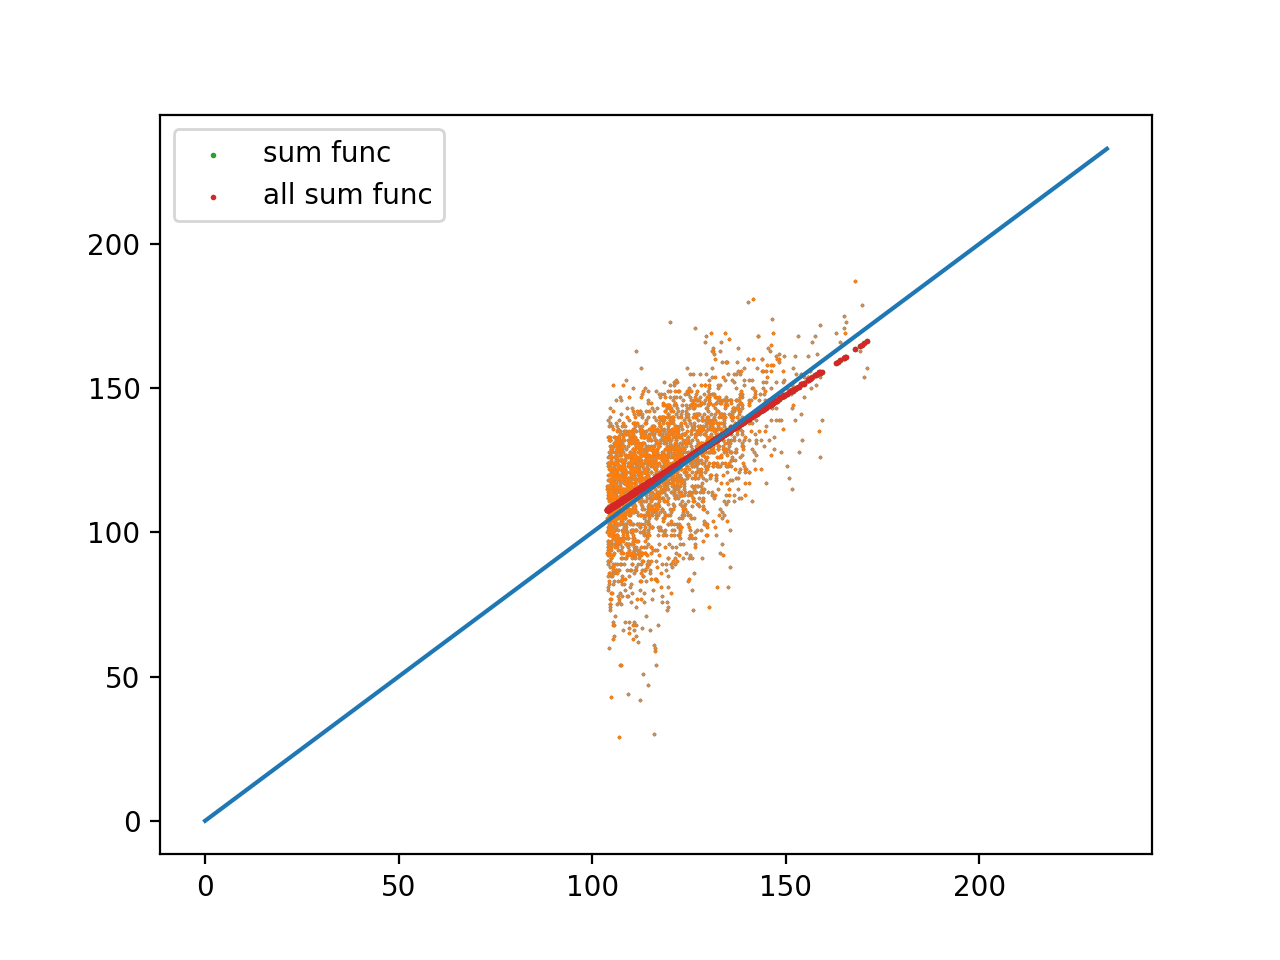

-0.000521477199086928 -0.0005948184156208136 -1.881019365685333e-07 0.9096787786745619 14.943408566869596
-0.000521477199086928 -0.0005948184156208136 -1.881019365685333e-07 0.9096787786745619 14.943408566869596


/Users/abhijit/Documents/GitHub/statbotics/scripts/.venv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [18]:
fig, ax = plt.subplots()

curr_data = all_data

score_mean = float(all_years_df[all_years_df.year == year].score_mean.iloc[0])
score_sd = float(all_years_df[all_years_df.year == year].score_sd.iloc[0])
score_cutoff = score_mean + score_sd

x = np.array([x[0] for x in data if sum(x[0]) > score_cutoff])
y = np.array([x[1] for x in data if sum(x[0]) > score_cutoff])
all_x = np.array([x[0] for x in all_data if sum(x[0]) > score_cutoff])
all_y = np.array([x[1] for x in all_data if sum(x[0]) > score_cutoff])

ax.scatter(x.sum(axis=1), y, s=0.1)
ax.scatter(all_x.sum(axis=1), all_y, s=0.1)

score_max = 3 * int(all_years_df[all_years_df.year == year].epa_max.iloc[0])
ax.plot(range(score_max), range(score_max))

def sum_func(X, a, b, c, d, e):
    (x1, x2, x3) = X
    x2 = (1 + a * x1) * x2
    x3 = (1 + b * (x1 + x2)) * x3
    s = x1 + x2 + x3
    # s = x1 + x2 + x3
    # return np.minimum(s, c + (d * (s - c)))
    return -max(c, 0) * s ** 2 + d * s + e
    # return c * s ** d + e
    
p0 = (0, 0, 0, 1, 0)

sum_popt, sum_pcov = curve_fit(sum_func, (x[:, 0], x[:, 1], x[:, 2]), y, p0)
all_sum_popt, all_sum_pcov = curve_fit(sum_func, (all_x[:, 0], all_x[:, 1], all_x[:, 2]), all_y, p0)
ax.scatter(x.sum(axis=1), sum_func((x[:, 0], x[:, 1], x[:, 2]), *sum_popt), s=1, label="sum func")
ax.scatter(all_x.sum(axis=1), sum_func((all_x[:, 0], all_x[:, 1], all_x[:, 2]), *all_sum_popt), s=1, label="all sum func")

ax.legend()
print(*sum_popt)
print(*all_sum_popt)

In [27]:
for i in range(193):
    candidates = (all_x.sum(axis=1) >= i) & (all_x.sum(axis=1) < i + 1)
    if sum(candidates) > 0:
        print(i, sum(all_y[candidates] > all_x.sum(axis=1)[candidates]) / sum(candidates))

103 0.5555555555555556
104 0.6081081081081081
105 0.6304347826086957
106 0.6694214876033058
107 0.6181818181818182
108 0.673469387755102
109 0.6464646464646465
110 0.6209677419354839
111 0.7272727272727273
112 0.6633663366336634
113 0.6666666666666666
114 0.5625
115 0.6477272727272727
116 0.5068493150684932
117 0.6101694915254238
118 0.6753246753246753
119 0.6388888888888888
120 0.6376811594202898
121 0.6233766233766234
122 0.5441176470588235
123 0.5102040816326531
124 0.6304347826086957
125 0.38461538461538464
126 0.5185185185185185
127 0.6326530612244898
128 0.4444444444444444
129 0.5531914893617021
130 0.7560975609756098
131 0.627906976744186
132 0.5121951219512195
133 0.5
134 0.5555555555555556
135 0.3225806451612903
136 0.5416666666666666
137 0.6
138 0.5172413793103449
139 0.2727272727272727
140 0.5384615384615384
141 0.5
142 0.5454545454545454
143 0.625
144 0.5384615384615384
145 0.875
146 0.6666666666666666
147 0.5
148 0.5
149 0.6666666666666666
150 0.0
151 0.14285714285714285
1

<IPython.core.display.Javascript object>


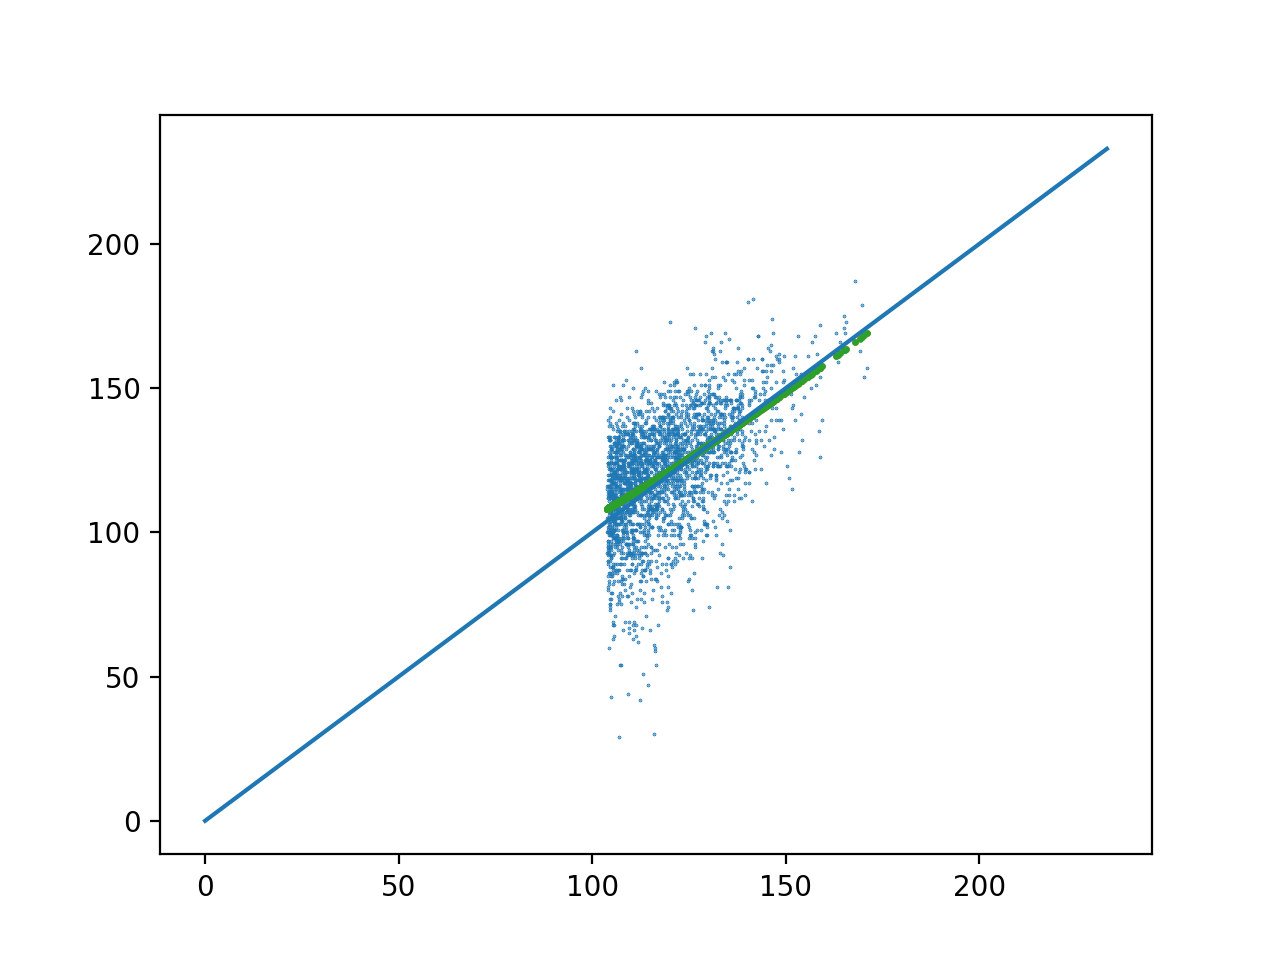

0.0015597846822829379 0.47980083968369686 41.517806125246246
0.06704348487245977 1.4535722763275665 50.98356992380614


In [9]:
fig, ax = plt.subplots()

score_mean = float(all_years_df[all_years_df.year == year].score_mean.iloc[0])
score_sd = float(all_years_df[all_years_df.year == year].score_sd.iloc[0])
score_cutoff = score_mean + score_sd

x = np.array([sum(x[0]) for x in data if sum(x[0]) > score_cutoff])
y = np.array([x[1] for x in data if sum(x[0]) > score_cutoff])

ax.scatter(x, y, s=0.1)

score_max = 3 * int(all_years_df[all_years_df.year == year].epa_max.iloc[0])
ax.plot(range(score_max), range(score_max))

def func(x, a, b, c):
    return a * x ** 2 + b * x + c

popt, pcov = curve_fit(func, x, y)
ax.scatter(x, func(x, *popt), s=2)

def func2(x, a, b, c):
    # return np.minimum(x, b + (c * (x - b)))
    return a * x ** b + c

popt2, pcov2 = curve_fit(func2, x, y, maxfev=20000)
ax.scatter(x, func2(x, *popt2), s=2)

print(*popt)
print(*popt2)

In [10]:
class TeamYear:
    def __init__(self, init):
        self.count = 0
        self.total = [init]
        
    def add_match(self, count, total):
        self.count += count
        self.total.append(total)

In [11]:
class ModelStats:
    def __init__(self):
        self.win_prob = []
        self.score_pred = []
        
    def record_stats(self, match, red_pred, blue_pred, win_prob):
        winner = {"blue": 0, "red": 1, "draw": 0.5}[match.winner]
        common = {"week": match.week, "event": match.event, "playoff": match.playoff, "key": match.key}
        
        self.win_prob.append({
            **common, 
            "winner": match.winner, 
            "win_prob": win_prob, 
            "conf": max(win_prob, 1 - win_prob), 
            "acc": (win_prob > 0.5) == winner, 
            "mse": (winner - win_prob) ** 2,
        })
        
        self.score_pred.append({
            **common,
            "pred": red_pred,
            "actual": match.red_no_fouls,
            "mse": (red_pred - match.red_no_fouls) ** 2,
            "mae": abs(red_pred - match.red_no_fouls),
            "err": match.red_no_fouls - red_pred,
        })
        
        self.score_pred.append({
            **common,
            "pred": blue_pred,
            "actual": match.blue_no_fouls,
            "mse": (blue_pred - match.blue_no_fouls) ** 2,
            "mae": abs(blue_pred - match.blue_no_fouls),
            "err": match.blue_no_fouls - blue_pred,
        })
            
    def print_stats(self):
        win_prob_df = pd.DataFrame(self.win_prob)
        score_pred_df = pd.DataFrame(self.score_pred)
        
        def agg_win_prob(name, _filter):
            temp_df = _filter(win_prob_df)
            temp = temp_df.agg({"event": "count", "conf": "mean", "acc": "mean", "mse": "mean"})
            rounded = [f"{temp.conf:.4f}", f"{temp.acc:.4f}", f"{temp.mse:.4f}"]
            print("\t".join([name + "\t", str(int(temp.event))] + rounded))
            
        def agg_score_pred(name, _filter):
            temp_df = _filter(score_pred_df)
            temp = temp_df.agg({"event": "count", "mse": "mean", "mae": "mean", "err": "mean"})
            rounded = [f"{temp.mse ** 0.5:.2f}", f"{temp.mae:2f}", f"{temp.err:.2f}"]
            print("\t".join([name + "\t", str(int(temp.event))] + rounded))
            
        print("Win Prob")
        print("Category\tCount\tConf\tAcc\tMSE")
        agg_win_prob("Season", lambda x: x[(x.week < 8)])
        agg_win_prob("Champs", lambda x: x[(x.week == 8)])
        agg_win_prob("Quals", lambda x: x[(x.playoff == False)])
        agg_win_prob("Elims", lambda x: x[(x.playoff == True)])
        agg_win_prob("Champs Elims", lambda x: x[(x.week == 8) & (x.playoff == True)])
        agg_win_prob("Total", lambda x: x)
        print()
        print()
        
        print("Score Pred")
        print("Category\tCount\tMSE\tMAE\tErr")
        agg_score_pred("Season", lambda x: x[(x.week < 8)])
        agg_score_pred("Champs", lambda x: x[(x.week == 8)])
        agg_score_pred("Low S", lambda x: x[(x.pred < score_cutoff)])
        agg_score_pred("High S", lambda x: x[(x.pred >= score_cutoff)])
        agg_score_pred("Total", lambda x: x)
        print()

In [12]:
starting_epas = {x.team: x.epa_start for _, x in team_years_df.iterrows()}

# print(starting_epas[5511])

In [13]:
def margin_func(x):
    return min(1, max(0, 1 / 24 * (x - 12)))


def percent_func(x):
    return min(0.5, max(0.3, 0.5 - 0.2 / 6 * (x - 6)))


MEAN = all_years_df[all_years_df.year == year].score_mean.iloc[0]
SD = all_years_df[all_years_df.year == year].score_sd.iloc[0]


def process_season(use_correction):
    team_years = {}
    model_stats = ModelStats()
    champs_count, champs_abs, champs_mse = 0, 0, 0
    for _, t in team_years_df.iterrows():
        team = t.team
        prior = MEAN / 3
        if team in starting_epas:
            prior = starting_epas[team]
            
        team_years[team] = TeamYear(prior)

    for _, match in matches_df.iterrows():
        red_teams = [int(match.red_1), int(match.red_2), int(match.red_3)]
        blue_teams = [int(match.blue_1), int(match.blue_2), int(match.blue_3)]

        red_pred = sum([team_years[t].total[-1] for t in red_teams])
        blue_pred = sum([team_years[t].total[-1] for t in blue_teams])
        
        if use_correction and red_pred > score_mean:
            red_pred = sorted([team_years[t].total[-1] for t in red_teams], reverse=True)
            red_pred = sum_func(red_pred, *sum_popt)
        
        if use_correction and blue_pred > score_mean:
            blue_pred = sorted([team_years[t].total[-1] for t in blue_teams], reverse=True)
            blue_pred = sum_func(blue_pred, *sum_popt)
            # red_pred = func(red_pred, *popt)
            # blue_pred = func(blue_pred, *popt)
            
        if match.week == 8 and match.playoff:
            # print(match.key, red_pred, blue_pred, red_accessor(match), blue_accessor(match))
            champs_abs += (red_pred - red_accessor(match))
            champs_abs += (blue_pred - blue_accessor(match))
            champs_mse += (red_pred - red_accessor(match)) ** 2
            champs_mse += (blue_pred - blue_accessor(match)) ** 2
            champs_count += 2
        
        win_prob = 1 / (1 + 10 ** (-5/8 * (red_pred - blue_pred) / SD))
        
        model_stats.record_stats(match, red_pred, blue_pred, win_prob)
        
        weight = 1 / 3 if match.playoff else 1

        red_score = red_accessor(match)
        blue_score = blue_accessor(match)
        for teams, my_score, opp_score, my_pred, opp_pred in [
            (red_teams, red_score, blue_score, red_pred, blue_pred),
            (blue_teams, blue_score, red_score, blue_pred, red_pred),
        ]:
            for team in teams:
                team_year = team_years[team]
                percent, margin_factor = percent_func(team_year.count), margin_func(team_year.count)
                error = ((my_score - my_pred) + margin_factor * (opp_pred - opp_score)) / (1 + margin_factor)
                total = team_year.total[-1] + percent * weight * error / 3
                team_year.add_match(0 if match.playoff else 1, total)
    
    model_stats.print_stats()
    if champs_count > 0:
        print(champs_abs / champs_count)
        print(champs_mse / champs_count)
    return team_years

print("No Correction")
team_years = process_season(False)
print()

print("Correction")
team_years_with_correction = process_season(True)

No Correction
Win Prob
Category	Count	Conf	Acc	MSE
Season		10400	0.7042	0.7532	0.1618
Champs		0	nan	nan	nan
Quals		8546	0.7042	0.7570	0.1599
Elims		1854	0.7043	0.7357	0.1706
Champs Elims		0	nan	nan	nan
Total		10400	0.7042	0.7532	0.1618


Score Pred
Category	Count	MSE	MAE	Err
Season		20800	17.87	14.307978	2.64
Champs		0	nan	nan	nan
Low S		18189	18.03	14.473126	2.74
High S		2611	16.73	13.157506	2.00
Total		20800	17.87	14.307978	2.64


Correction
Win Prob
Category	Count	Conf	Acc	MSE
Season		10400	0.7086	0.7506	0.1621
Champs		0	nan	nan	nan
Quals		8546	0.7115	0.7549	0.1602
Elims		1854	0.6952	0.7309	0.1707
Champs Elims		0	nan	nan	nan
Total		10400	0.7086	0.7506	0.1621


Score Pred
Category	Count	MSE	MAE	Err
Season		20800	17.92	14.325343	2.42
Champs		0	nan	nan	nan
Low S		18133	18.05	14.434878	2.20
High S		2667	16.97	13.580610	3.86
Total		20800	17.92	14.325343	2.42



<IPython.core.display.Javascript object>


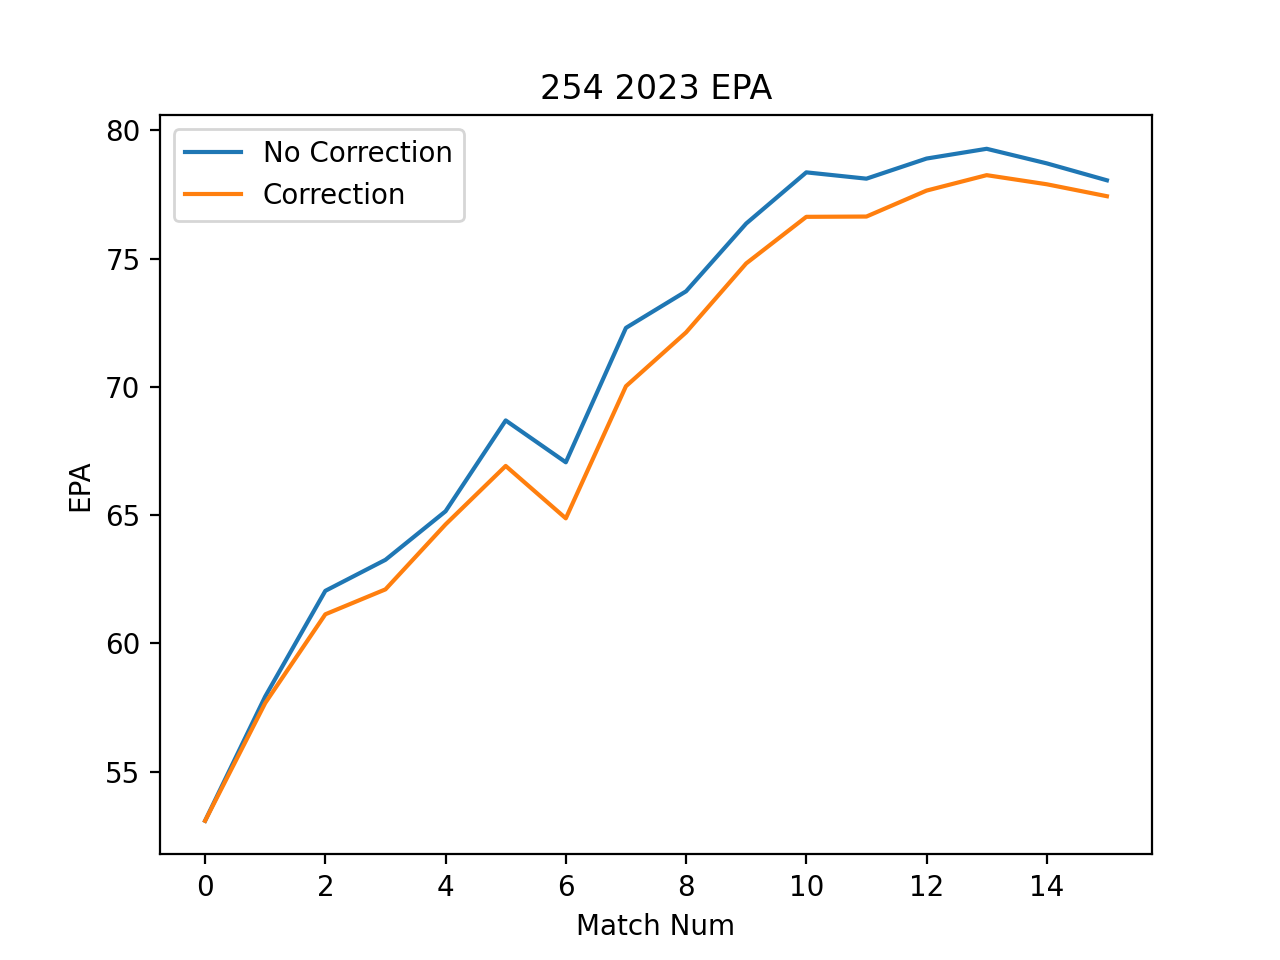

In [14]:
fig, ax = plt.subplots()

team = 254

team_ratings = team_years[team].total
team_ratings_with_priors = team_years_with_correction[team].total
N = len(team_ratings)

ax.plot(range(N), team_ratings, label="No Correction")
ax.plot(range(N), team_ratings_with_priors, label="Correction")

ax.legend()
ax.set_xlabel("Match Num")
ax.set_ylabel("EPA")
ax.set_title(str(team) + " " + str(year) + " EPA")
fig.show()

In [15]:
end_team_ratings = {k: v.total[-1] for (k, v) in team_years.items() if not math.isnan(v.total[-1])}
print(sorted(end_team_ratings.items(), key=lambda x: -x[1])[:8])

end_team_ratings_with_correction = {k: v.total[-1] for (k, v) in team_years_with_correction.items() if not math.isnan(v.total[-1])}
print(sorted(end_team_ratings_with_correction.items(), key=lambda x: -x[1])[:8])

for x in sorted(end_team_ratings.items(), key=lambda x: -x[1])[:25]:
    print(x[0], "\t", round(x[1], 4), "\t", round(end_team_ratings_with_correction[x[0]], 4))

[(2056, 78.13076845629357), (254, 78.05057217146579), (1323, 70.87873945587054), (1678, 70.17682095214069), (3538, 69.82677376632574), (3005, 69.73485648652382), (4499, 68.52287276657583), (2337, 68.33965293036988)]
[(254, 77.42991828659038), (2056, 75.44001423257295), (1323, 71.17205105528963), (1678, 70.267802202143), (3005, 68.16667278577208), (3538, 66.8901563074144), (4499, 66.7876591136663), (6329, 66.59223805420325)]
2056 	 78.1308 	 75.44
254 	 78.0506 	 77.4299
1323 	 70.8787 	 71.1721
1678 	 70.1768 	 70.2678
3538 	 69.8268 	 66.8902
3005 	 69.7349 	 68.1667
4499 	 68.5229 	 66.7877
2337 	 68.3397 	 64.8184
176 	 67.4285 	 65.2698
6329 	 67.175 	 66.5922
6672 	 66.1975 	 64.5389
3683 	 66.1669 	 65.4749
1619 	 65.4667 	 63.1383
2910 	 65.341 	 65.068
1577 	 63.9437 	 64.7735
2767 	 63.8448 	 61.7495
2468 	 62.8256 	 60.3002
1987 	 62.6395 	 60.0621
1706 	 62.4465 	 61.7847
4414 	 62.241 	 61.0329
67 	 62.2308 	 60.9322
1538 	 62.1581 	 60.3388
1756 	 61.5806 	 61.0653
3015 	 